In [29]:
import numpy as np
import numpy.linalg as LA
import time
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# Regression

In [30]:
ambient_dimension = 128
avg_num = int(1e+3) # number of experiment average
noise_std = 0.5
factor = 0.8
snr = 4
sign_false_rate = 0.2


# Data generation model:
# 1. 1-sparse vector
true_theta = np.zeros([ambient_dimension, 1])
signal_position = [0]
for i in signal_position:
    true_theta[i] = 1
# 2. random gaussian
# true_theta = np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T
# true_theta /= LA.norm(true_theta)
# true_theta = true_theta.reshape(-1, 1)
# 3. dense signal with spikes
#true_theta = np.random.multivariate_normal([0] * ambient_dimension, np.identity(ambient_dimension)).T
#for i in range(20):
#    true_theta[i] = 0
#spike_strength = 10000
#true_theta[0] = np.sqrt(spike_strength) * LA.norm(true_theta)

# 2. input data distribution
Sigma = np.identity(ambient_dimension)
decay = 1
for i in range(ambient_dimension):
    Sigma[i, i] = decay ** abs(i) if i in signal_position else 0
    Sigma[i, i] = decay ** abs(i)
for i in range(1, ambient_dimension):
    Sigma[i,i-1] = 0
    Sigma[i-1, i] = 0

alpha = snr * noise_std ** 2 / (true_theta.T.dot(Sigma).dot(true_theta)[0][0])
Sigma *= alpha

#for i in signal_position:
#    true_theta[i] /= np.sqrt(Sigma[i, i])
#for i in range(20):
#    Sigma[i, i] = 1
#for i in range(20, ambient_dimension):
#    Sigma[i, i] = 0.2

#for i in range(ambient_dimension):
#    Sigma[i, i] = random.random()

In [31]:
# Estimator Function
def get_ridge_est(X, y, ridge):
    d = X.shape[1]
    n = X.shape[0]
    reg = np.identity(d)
    S = LA.inv(X.T.dot(X) + n * ridge * reg).dot(X.T) if ridge > 0 else LA.pinv(X.T.dot(X)).dot(X.T)
    return S.dot(y)

def get_het_ridge_est(X, y, ridge_list):
    d = X.shape[1]
    n = X.shape[0]
    reg = n * np.identity(d)
    for i in range(d):
        reg[i, i] *= ridge_list[i]
    S = LA.pinv(X.T.dot(X) + reg).dot(X.T)
    return S.dot(y)

def get_pepper_est(X, y, ridge, p):
    d = X.shape[1]
    n = X.shape[0]
    reg = np.identity(d)
    psi = p / (1 - p)
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    S = LA.inv(Cov + psi / (1 - p) * n * ridge * reg + psi * diag).dot(X.T) if (ridge > 0 or p > 0) else LA.pinv(X.T.dot(X)).dot(X.T)
    return S.dot(y)

def get_lse_est(X, y):
    Cov = X.T.dot(X)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X.T)
    return S.dot(y)

def get_lse_est_2(X, y):
    Cov = X.T.dot(X)
    mu = X.mean(axis=0).reshape(-1, 1)
    n = X.shape[0]
    #Z1 = n * mu.dot(mu.T)
    Z1 = Cov - 0.5 * np.diag(np.diag(Cov))
    A1 = np.concatenate((Cov, Z1), axis=1)
    A2 = np.concatenate((Z1.T, Cov), axis=1)
    Z = np.concatenate((A1, A2), axis=0)
    #B = np.concatenate((X.T, mu.dot(np.ones([1, n]))), axis=0).dot(y)
    B = np.concatenate((X.T, X.T), axis=0).dot(y)
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    return LA.pinv(Z).dot(B)

def get_knockoff_est(X, y, D):
    Cov = X.T.dot(X)
    A = Cov.dot(np.identity(ambient_dimension) - LA.inv(Sigma).dot(D))
    A1 = np.concatenate((Cov, A), axis=1)
    B = 2 * D - D.dot(LA.inv(Sigma)).dot(D) + Cov - Cov.dot(LA.inv(Sigma)).dot(D) - D.dot(LA.inv(Sigma)).dot(Cov) + \
        D.dot(LA.inv(Sigma)).dot(Cov).dot(LA.inv(Sigma)).dot(D)
    A2 = np.concatenate((A.T, B), axis=1)
    Z = np.concatenate((A1, A2), axis=0)
    C = np.concatenate((np.identity(ambient_dimension), np.identity(ambient_dimension) - D.dot(LA.inv(Sigma))), axis=0)
    return LA.pinv(Z).dot(C).dot(X.T).dot(y)

def get_crop_est(X, y, p):
    Cov = X.T.dot(X)
    diag = np.diag(np.diag(Cov))
    Z = Cov + p / (1 - p) * diag
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_crop_est_bar(X, y, p):
    Cov = X.T.dot(X)
    n = X.shape[0]
    Z = Cov + p / (1 - p) * n * Sigma
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

# heterogeneous mask
def get_het_crop_est(X, y, p, het_ratio):
    Cov = X.T.dot(X)
    p1 = p / het_ratio
    diag = np.diag(np.diag(Cov))
    reg = diag
    for i in range(Cov.shape[0]):
        reg[i, i] *= p / (1 - p) if i != signal_position else p1 / (1 - p1)
    Z = Cov + reg
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_het_crop_est_bar(X, y, p, het_ratio):
    Cov = X.T.dot(X)
    n = X.shape[0]
    p1 = p / het_ratio
    reg = n * Sigma
    for i in range(Cov.shape[0]):
        reg[i, i] *= p / (1 - p) if i != signal_position else p1 / (1 - p1)
    Z = Cov + reg
    S = LA.inv(Z).dot(X.T)
    return S.dot(y)

def get_risk(a, b):
    diff = a - b
    return  diff.T.dot(Sigma).dot(diff)[0, 0]

def get_norm(theta):
    return  theta.T.dot(Sigma).dot(theta)[0, 0]

def get_risk_cls(su, cn):
    return  0.5 - np.arctan(su/cn) / np.pi

def get_su(theta):
    pos = signal_position[0]
    return theta[pos,0] * np.sqrt(Sigma[pos,pos])

def get_cn(theta):
    pos = signal_position[0]
    return np.sqrt(theta.T.dot(Sigma).dot(theta)[0, 0] - (theta[pos,0] * np.sqrt(Sigma[pos,pos]))**2)

In [32]:
# Choose the type of augmentation:
# set range of parameters of DA
# "crop_finite": dropout with k fixed patterns, "crop": dropout with p dropout rate, 
# "ridge": add gaussian with power sigma s^2, "proj": random projection with k dimensional space,
# "mixup": mix-up with beta distribution parameter b
#ridge_params = np.concatenate((np.zeros(1), np.power(2, np.linspace(-10, -6, num=0)), np.power(2, np.linspace(-5, 2, num=10)), np.power(2, np.linspace(2, 20, num=0))))
ridge_params = [0, 0.2, 0.5, 1, 2, 5]
ridge_params = np.concatenate((np.linspace(0, 1, 0), np.linspace(0, 2, 10)))
for i in range(len(ridge_params)):
    ridge_params[i] = ridge_params[i] ** 2
crop_params = np.concatenate((np.linspace(0, 1e-3, num=0), np.linspace(0, 0.4, num=6), np.linspace(.5, .99, num=4)))
crop_params = [0.01, 0.1, 0.3, 0.5, 0.9]
#crop_params = [0.3]

#ridge_params = [1]
#crop_params = [0.3]
#pepper_params = {"ridge": [1], "drop_prob": [0.3]}

In [33]:
sample_list = range(5, int(ambient_dimension * 1.5), 5)
risk_lse = np.zeros([avg_num, len(sample_list)])

risk_crop = np.zeros([avg_num, len(crop_params), len(sample_list)])
risk_crop_biased = np.zeros([avg_num, len(crop_params), len(sample_list)])

# Simulate risk
np.random.seed(1)
start = time.time()
for i in tqdm(range(avg_num)):

    # generate training data
    X = np.zeros([sample_list[-1], ambient_dimension])
    y = np.zeros([sample_list[-1], 1])
    noise_vec = np.zeros([sample_list[-1], 1])
    for j in range(X.shape[0]):
        X[j, :] = np.random.multivariate_normal([0] * ambient_dimension, Sigma).reshape(-1)
        noise_vec[j, :] = np.random.normal(0, noise_std)
        y[j, :] = np.inner(true_theta.reshape(-1), X[j, :]) + noise_vec[j, :]
    for k in range(len(sample_list)):
        sample = sample_list[k]
        X_tr = X[:sample, :]
        y_tr = y[:sample, :]
        noise_tr = noise_vec[:sample, :]
        theta_lse = get_lse_est(X_tr, y_tr)
        risk_lse[i, k] = get_risk(theta_lse, true_theta)

        # get loss
        for j in range(len(crop_params)):
            theta = get_crop_est(X_tr, y_tr, crop_params[j])
            theta_b = get_crop_est(X_tr, y_tr, crop_params[j]) / (1 - crop_params[j])
            risk_crop[i, j, k] = get_risk(theta, true_theta)
            risk_crop_biased[i, j, k] = get_risk(theta_b, true_theta)

risk_crop_mean = np.mean(risk_crop, axis=0)
risk_crop_biased_mean = np.mean(risk_crop_biased, axis=0)
risk_crop_std = np.std(risk_crop, axis=0)
risk_crop_biased_std = np.std(risk_crop_biased, axis=0)

risk_lse = np.mean(risk_lse, axis=0)

#risk_ridge_ce /= avg_num
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

100%|██████████| 1000/1000 [23:33<00:00,  1.41s/it]

Complete in 1413.04 sec


In [34]:
sample_list = range(5, int(ambient_dimension * 1.5), 5)
risk_lse_cls = np.zeros([avg_num, len(sample_list)])

risk_crop_cls = np.zeros([avg_num, len(crop_params), len(sample_list)])
risk_crop_biased_cls = np.zeros([avg_num, len(crop_params), len(sample_list)])

# Simulate risk
np.random.seed(1)
start = time.time()
for i in tqdm(range(avg_num)):

    # generate training data
    X = np.zeros([sample_list[-1], ambient_dimension])
    y = np.zeros([sample_list[-1], 1])
    for j in range(X.shape[0]):
        X[j, :] = np.random.multivariate_normal([0] * ambient_dimension, Sigma).reshape(-1)
        y[j, :] = np.sign(np.inner(true_theta.reshape(-1), X[j, :]))
        if random.uniform(0, 1) < sign_false_rate:
            y[j, :] *= -1

    for k in range(len(sample_list)):
        sample = sample_list[k]
        X_tr = X[:sample, :]
        y_tr = y[:sample, :]
        theta_lse = get_lse_est(X_tr, y_tr)

        su_lse = get_su(theta_lse)
        cn_lse = get_cn(theta_lse)
        risk_lse_cls[i, k] = get_risk_cls(su_lse, cn_lse)

        # get loss
        for j in range(len(crop_params)):
            theta = get_crop_est(X_tr, y_tr, crop_params[j])
            theta_b = get_crop_est(X_tr, y_tr, crop_params[j]) / (1 - crop_params[j])
            su_crop = get_su(theta)
            cn_crop = get_cn(theta)
            su_crop_b = get_su(theta_b)
            cn_crop_b = get_cn(theta_b)
            risk_crop_cls[i, j, k] = get_risk_cls(su_crop, cn_crop)
            risk_crop_biased_cls[i, j, k] = get_risk_cls(su_crop_b, cn_crop_b)

risk_crop_cls_mean = np.mean(risk_crop_cls, axis=0)
risk_crop_cls_std = np.std(risk_crop_cls, axis=0)
risk_crop_biased_cls_mean = np.mean(risk_crop_biased_cls, axis=0)
risk_crop_biased_cls_std = np.std(risk_crop_biased_cls, axis=0)

risk_lse_cls = np.mean(risk_lse_cls, axis=0)

#risk_ridge_ce /= avg_num
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

100%|██████████| 1000/1000 [22:18<00:00,  1.34s/it]

Complete in 1338.02 sec


Text(0.5, 1.0, 'Biased Random Mask')

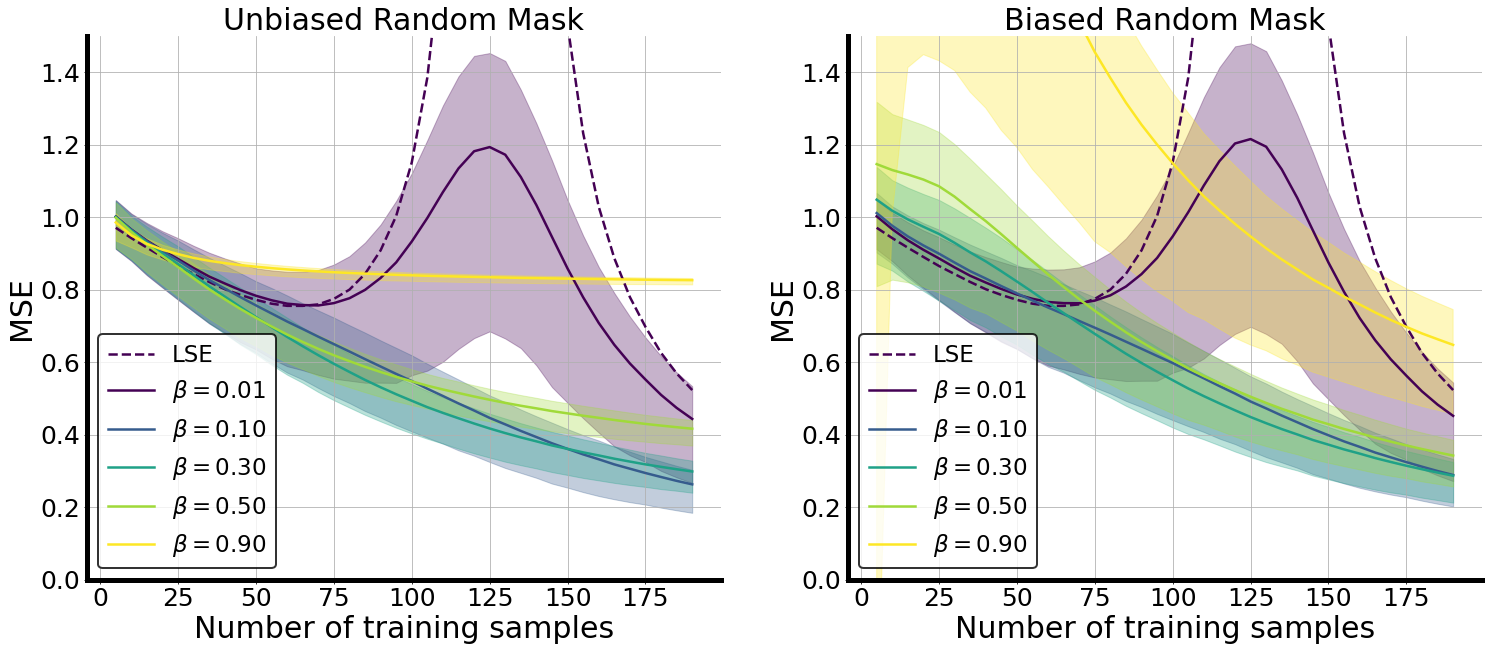

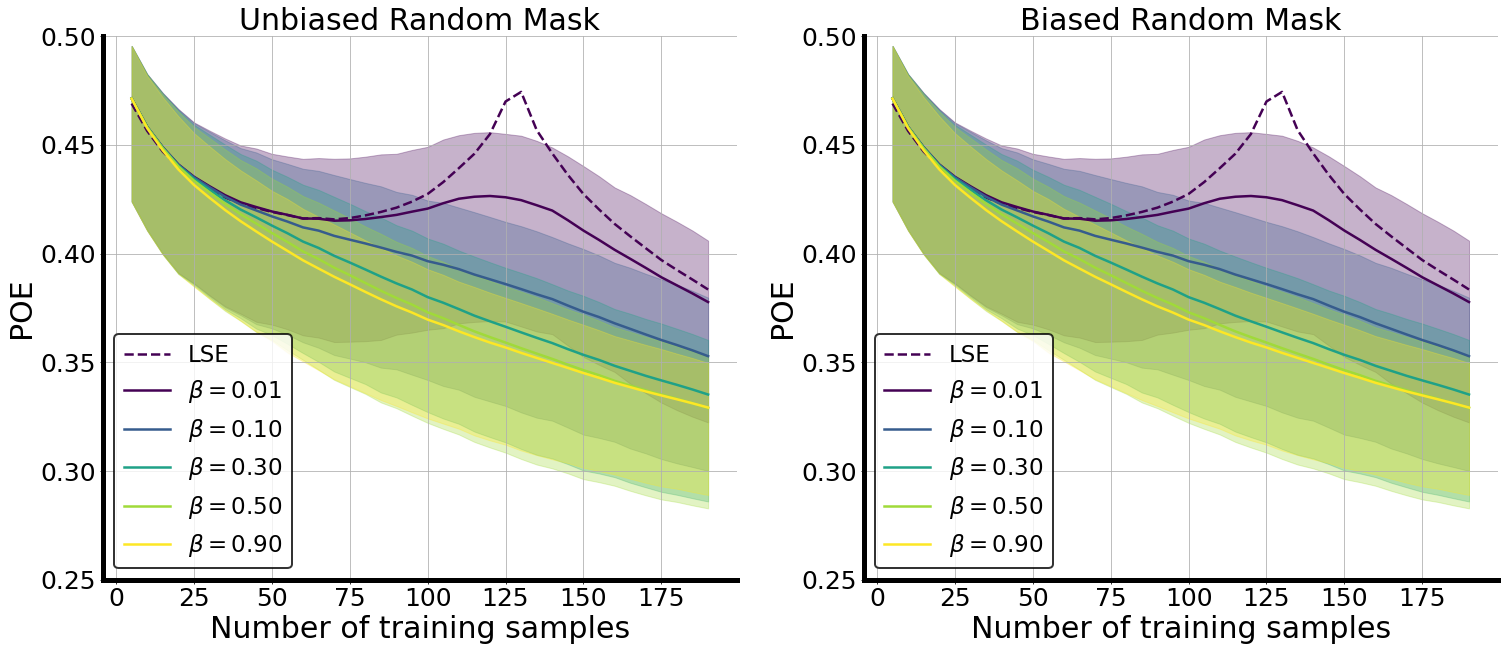

In [47]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 8)
linewidth = 2.5
fac = 4
fontsize = 30
legendsize = 23
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 5

plt.figure(figsize=(25, 10))
y_min = 0; y_max = 1.5
tick_size = 25
x_ax = sample_list
ax=plt.subplot(1,2,1)
plt.plot(x_ax, risk_lse, ls='--',  linewidth=linewidth, label='LSE', c=viridis(0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(True)
for i in range(len(crop_params)):
    plt.plot(x_ax, risk_crop_mean[i, :], label=r'$\beta=$'+format(round(crop_params[i],3), ".2f"), linewidth=linewidth, c=viridis(i/fac))
    plt.fill_between(x_ax, risk_crop_mean[i, :] - 1.96 * risk_crop_std[i, :],  risk_crop_mean[i, :] + risk_crop_std[i, :], color=viridis(i/fac),alpha=0.3)
leg = plt.legend(loc="lower left", prop={'size': legendsize})
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
plt.xlabel('Number of training samples', fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim(y_min, y_max)
plt.title( 'Unbiased Random Mask', fontsize=fontsize)
#plt.grid()

ax=plt.subplot(1,2,2)
plt.plot(x_ax, risk_lse, ls='--',  linewidth=linewidth, label='LSE', c=viridis(0))
for i in range(len(crop_params)):
    plt.plot(x_ax, risk_crop_biased_mean[i, :], label=r'$\beta=$'+format(round(crop_params[i],3), ".2f"), linewidth=linewidth, c=viridis(i/fac))
    plt.fill_between(x_ax, risk_crop_biased_mean[i, :] - 1.96 * risk_crop_biased_std[i, :],  risk_crop_biased_mean[i, :] + risk_crop_biased_std[i, :], color=viridis(i/fac),alpha=0.3)
leg = plt.legend(loc="lower left", prop={'size': legendsize})
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
plt.xlabel('Number of training samples', fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(True)
plt.ylim(y_min, y_max)
plt.title( 'Biased Random Mask', fontsize=fontsize)
#plt.grid()

plt.figure(figsize=(25, 10))
y_min = 0.25; y_max = .5
tick_size = 25
x_ax = sample_list
ax = plt.subplot(1,2,1)
plt.plot(x_ax, risk_lse_cls, ls='--',  linewidth=linewidth, label='LSE', c=viridis(0))
for i in range(len(crop_params)):
    plt.plot(x_ax, risk_crop_cls_mean[i, :], label=r'$\beta=$'+format(round(crop_params[i],3), ".2f"), linewidth=linewidth, c=viridis(i/fac))
    plt.fill_between(x_ax, risk_crop_cls_mean[i, :] - 1.96 * risk_crop_cls_std[i, :],  risk_crop_cls_mean[i, :] + risk_crop_cls_std[i, :], color=viridis(i/fac),alpha=0.3)
leg = plt.legend(loc="lower left", prop={'size': legendsize})
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
plt.xlabel('Number of training samples', fontsize=fontsize)
plt.ylabel('POE', fontsize=fontsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim(y_min, y_max)
plt.title( 'Unbiased Random Mask', fontsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(True)
#plt.grid()

ax=plt.subplot(1,2,2)
plt.plot(x_ax, risk_lse_cls, ls='--',  linewidth=linewidth, label='LSE', c=viridis(0))
for i in range(len(crop_params)):
    plt.plot(x_ax, risk_crop_biased_cls_mean[i, :], label=r'$\beta=$'+format(round(crop_params[i],3), ".2f"), linewidth=linewidth, c=viridis(i/fac))
    plt.fill_between(x_ax, risk_crop_biased_cls_mean[i, :] - 1.96 * risk_crop_biased_cls_std[i, :],  risk_crop_biased_cls_mean[i, :] + risk_crop_biased_cls_std[i, :], color=viridis(i/fac),alpha=0.3)
leg = plt.legend(loc="lower left", prop={'size': legendsize})
leg.get_frame().set_linewidth(2.0)
leg.get_frame().set_edgecolor('black')
plt.xlabel('Number of training samples', fontsize=fontsize)
plt.ylabel('POE', fontsize=fontsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(True)
plt.ylim(y_min, y_max)
#plt.yscale('log')
plt.title( 'Biased Random Mask', fontsize=fontsize)
#plt.grid()